In [2]:
from gorillatracker.classification.metrics import analyse_embedding_space
import pandas as pd
import dill

base = "/workspaces/gorillatracker/emirhan"

# fp = f"{base}/gorillatracker/notebooks/ssl_embeddings.pkl"
fp = f"{base}/gorillatracker/ssl_embeddings_new.pkl"

with open(fp, "rb") as dill_file:
    df = dill.load(dill_file)

EOFError: Ran out of input

In [ ]:
import numpy as np

df["id"] = df["id"].apply(lambda x: int(x.item()))
df["embedding"] = df["embedding"].apply(lambda x: np.array([t.item() for t in x]))

print(df.head())
print(df["id"].count())
print(df["id"].nunique())
print(df["label_string"].nunique())
print(df["label"].nunique())

   index         id                                          embedding  \
0      0  198622468  [0.24645809829235077, 0.19448710978031158, 0.6...   
1      1   66519389  [-0.3058217167854309, -0.19159026443958282, -0...   
2      2   61781797  [0.6751120686531067, 0.07994581013917923, 0.63...   
3      3  201096588  [0.3494167923927307, -0.23327593505382538, 0.6...   
4      4   14152899  [0.8222890496253967, -0.33219802379608154, 1.7...   

    label label_string  tracking_id  
0  381108       381108       381108  
1  289797       289797       289797  
2  172057       172057       172057  
3  454907       454907       454907  
4   67195        67195        67195  
37596
37596
5877
5877


In [3]:
# Group by label and calculate the mean of the embeddings
centroid_df = df.groupby("label")["embedding"].apply(lambda x: list(pd.DataFrame(x.tolist()).mean())).reset_index()
centroid_df.columns = ["tracklet_id", "embedding"]

In [11]:
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm


def generate_results_df(df, k_values):

    embeddings = np.array(centroid_df["embedding"].tolist())

    # Initialize lists to store results
    results = []

    # Perform grid search
    for k in tqdm(k_values, desc="Grid Search Progress"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Update the 'label' column with cluster labels
        df["label"] = cluster_labels

        # Analyze the embedding space
        metrics = analyse_embedding_space(df)

        # Store results
        results.append({**metrics, "k": k})
    results_df = pd.DataFrame(results)
    return results_df


count = centroid_df.shape[0]
results_df = generate_results_df(centroid_df, range(1, count, 10000))

# Print the results
print(results_df.head())

Grid Search Progress: 100%|██████████| 20/20 [08:21<00:00, 25.06s/it]

    unclustered_ratio  global_max_dist  global_min_dist  global_avg_dist  \
0                 0.0        21.552046         1.768539        12.364468   
1                 0.0        21.552046         1.768539        12.364468   
2                 0.0        21.552046         1.768539        12.364468   
3                 0.0        21.552046         1.768539        12.364468   
4                 0.0        21.552046         1.768539        12.364468   
5                 0.0        21.552046         1.768539        12.364468   
6                 0.0        21.552046         1.768539        12.364468   
7                 0.0        21.552046         1.768539        12.364468   
8                 0.0        21.552046         1.768539        12.364468   
9                 0.0        21.552046         1.768539        12.364468   
10                0.0        21.552046         1.768539        12.364468   
11                0.0        21.552046         1.768539        12.364468   
12          

In [6]:
results_df.to_pickle("emirhan_metrics_df.pkl")

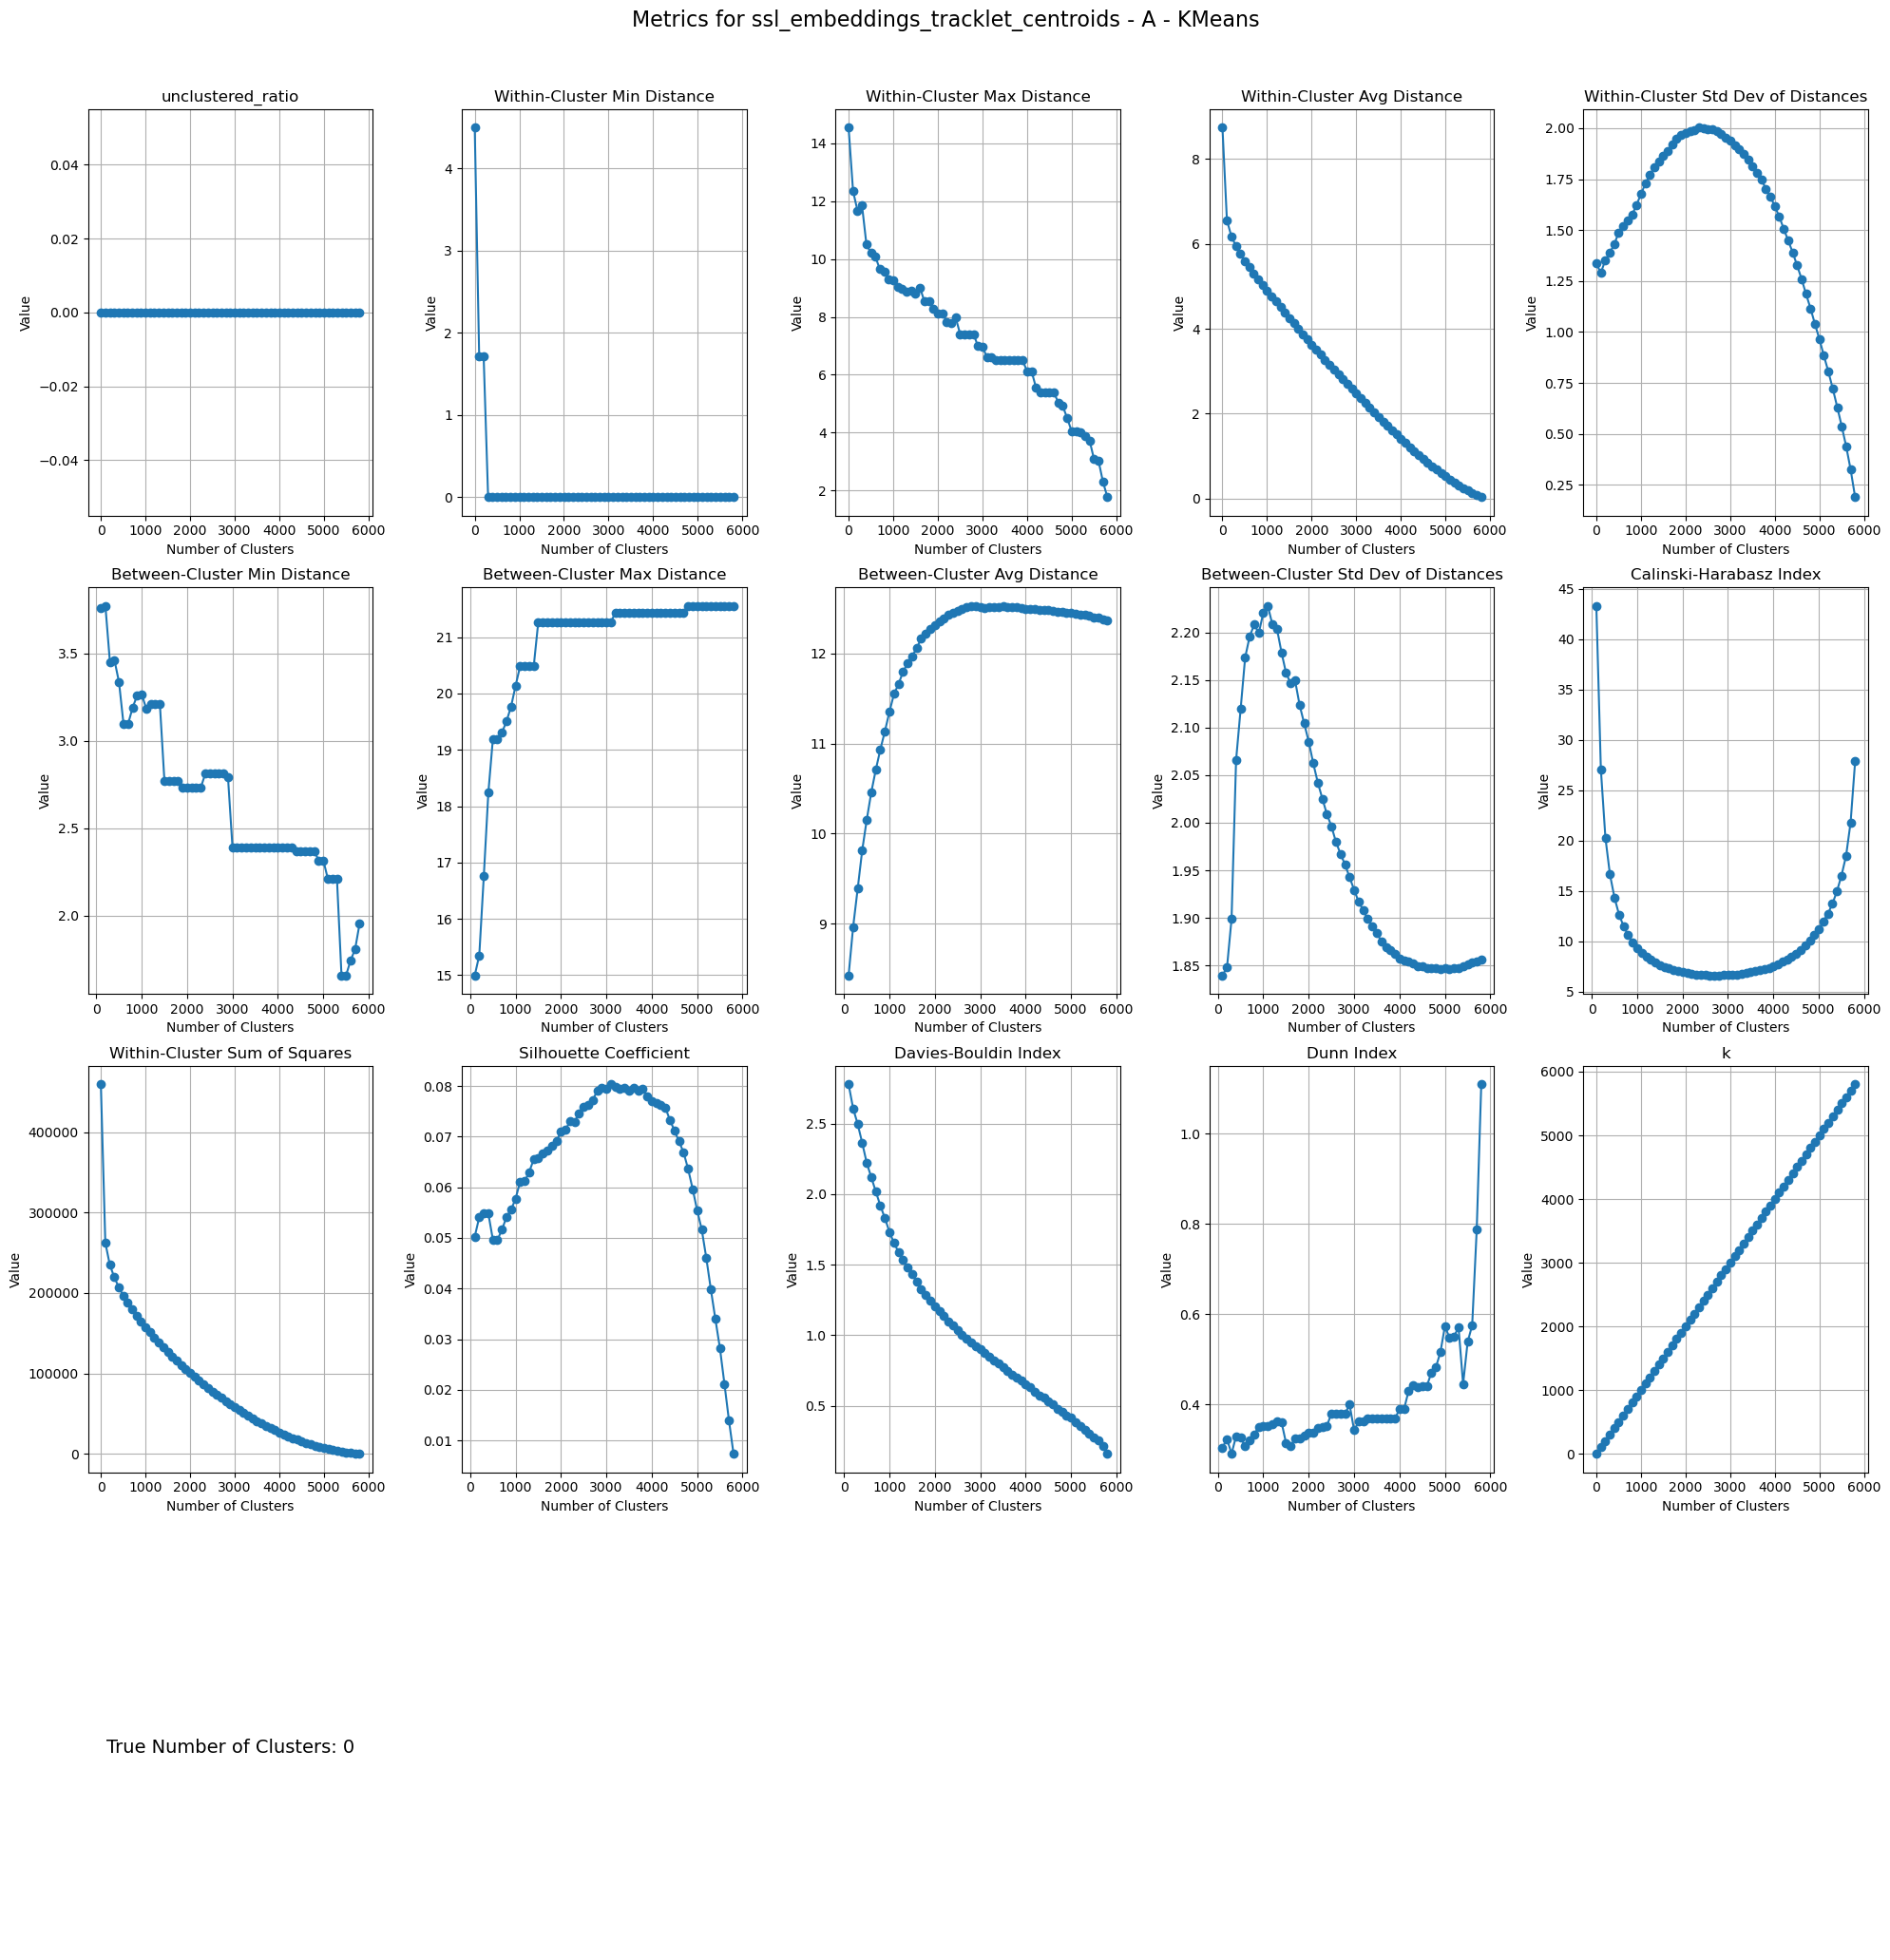

In [8]:
from gorillatracker.classification.clustering import visualize_alg_metrics
from gorillatracker.classification.metrics import formatted_names

dataset = "ssl_embeddings_tracklet_centroids"
model = "A"
algorithm = "KMeans"

results_df["dataset"] = dataset
results_df["model"] = model
results_df["algorithm"] = algorithm
results_df["algorithm_params"] = results_df["k"].apply(lambda x: {"n_clusters": x})
results_df["n_true_clusters"] = 0

visualize_alg_metrics(results_df, dataset, model, algorithm, formatted_names)

In [ ]:
k = results_df["k"].iloc[results_df["silhouette_coefficient"].idxmax()]
results_df = generate_results_df(centroid_df, range(k - 10000, k + 10000, 100))
dataset = "ssl_embeddings_tracklet_centroids"
model = "A"
algorithm = "KMeans"

results_df["dataset"] = dataset
results_df["model"] = model
results_df["algorithm"] = algorithm
results_df["algorithm_params"] = results_df["k"].apply(lambda x: {"n_clusters": x})
results_df["n_true_clusters"] = 0

visualize_alg_metrics(results_df, dataset, model, algorithm, formatted_names)
results_df.to_pickle("emirhan_metrics_df_finegrained.pkl")

In [10]:
k = results_df["k"].iloc[results_df["silhouette_coefficient"].idxmax()]
embeddings = np.array(centroid_df["embedding"].tolist())
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

final_df = centroid_df.copy()
final_df["label"] = cluster_labels
final_df.to_pickle("emirhan_clustered_df.pkl")
print(final_df.head())

   tracklet_id                                          embedding  label
0           36  [1.0812986969947815, -0.008819019794464112, -0...    877
1          184  [0.9193121194839478, -1.0246402025222778, 1.39...    813
2          364  [0.4899433344602585, 0.5379732400178909, 0.666...   2687
3          378  [0.8989161729812623, 0.12458963692188263, 0.96...    273
4          694  [-0.1158952098339796, -0.6083700060844421, 1.5...   1719


In [ ]:
import os

os.rename("emirhan_clustered_df.pkl", f"{base}/gorillatracker/complete_18_09_2024_clustered_df.pkl")